# Varying region specific parameters and connectivity

In this demo, we look at varying parameters and connectivity of specific regions.

Let's get set up:

In [12]:
%pylab inline
from tvb.simulator.lab import *
# ignore the ERROR about mayavi_tools, not required for us.

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Now, we'll create a baseline simulation:

In [119]:
conn = connectivity.Connectivity(load_default=True)

sim = simulator.Simulator(
    connectivity=conn,
    coupling=coupling.Linear(a=0.01),
    model=models.Generic2dOscillator(a=1.0),
    simulation_length=1000.0, # ms
    integrator=integrators.HeunDeterministic(dt=0.1)
)
sim.configure()
(time, trace), = sim.run()

2016-06-01 07:25:57,732 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.


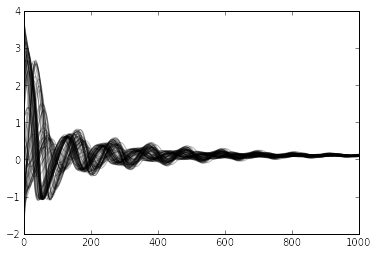

In [120]:
plot(time, trace[:, 0, :, 0], 'k', alpha=0.3);

So, this will be our baseline simulation, and when we change connectivity, we'll compare to baseline. 

First let's find two regions we'd want to change coupling strengths for. Just for example's sake, let's say that in a visuomotor task, visual and auditory regions will be coupled. We'll first find the indices in the matrix for these:

In [121]:
i_rV1, i_rA1,  = [list(conn.region_labels).index(name) for name in ('rV1', 'rA1')]
i_rV1, i_rA1

roi_names = ['rV1', 'rA1', 'rV2', 'rA2', 'lV1', 'lA1', 'lV2', 'lA2']
av_indices = []
for roi_name in roi_names:
    roi_index = find(conn.region_labels==roi_name)[0]
    av_indices.append(roi_index)

Next, we set up our parameter values, which here, for demo purposes, is just a linspace between the connectivity's minimum and maximum values:

In [122]:
av_coupling_values = linspace(conn.weights.min(), conn.weights.max(), 5)
av_coupling_values

array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ])

We'll also covary those coupling values with a threshold in the AV regions

In [123]:
av_threshold_values = linspace(0.5, 2.0, 5)
av_threshold_values

array([ 0.5  ,  0.875,  1.25 ,  1.625,  2.   ])

Now, we can run simulations for each modification of connectivity and collect the changes against baseline

In [124]:
changes = []

for av_coupling, av_thresh in zip(av_coupling_values, av_threshold_values):
    
    conn = connectivity.Connectivity(load_default=True)
    
    # modifiy node thresholds
    g2d = models.Generic2dOscillator()
    a = numpy.ones((conn.weights.shape[0], ))
    a[av_indices] = av_thresh
    g2d.a = a
    
    # modify weights (SC)
    for i in av_indices:
        for j in av_indices:
            conn.weights[i, j] = av_coupling
    
    # run simulation
    sim = simulator.Simulator(
        connectivity=conn,
        model=g2d,
        simulation_length=1000.0, # ms
        coupling=coupling.Linear(a=0.01),
        integrator=integrators.HeunDeterministic(dt=0.1)
    )
    sim.configure()
    (_, av_trace), = sim.run()
    
    # keep just the difference with baseline
    changes.append(av_trace - trace)
    
    # let us know progress
    print av_coupling, 'done'
    
changes = array(changes)

2016-06-01 07:26:03,929 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
0.0 done
2016-06-01 07:26:09,839 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
0.75 done
2016-06-01 07:26:15,812 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
1.5 done
2016-06-01 07:26:22,356 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
2.25 done
2016-06-01 07:26:28,230 - WARNING - tvb.basic.readers - File hemispheres not found in ZIP.
3.0 done


Now, let's plot the changes:

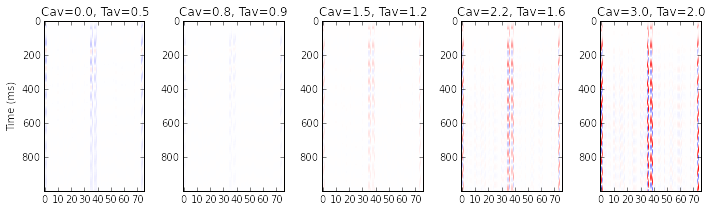

In [125]:
cmin, cmax = percentile(changes[:, time>200], [0, 100])
vmax = cmax if cmax > -cmin else -cmin

figure(figsize=(10, 3))
for i in range(5):
    subplot(1, 5, i + 1)
    imshow(changes[i, :, 0, :, 0], interpolation='none', vmin=-vmax, vmax=vmax, aspect='auto', cmap='bwr')
    if i == 0:
        ylabel('Time (ms)')
    title('Cav=%0.1f, Tav=%0.1f' % (av_coupling_values[i], av_threshold_values[i]))
tight_layout()

We can see that across parameter variations, the stronger "task condition" recruits other regions in the brain more strongly, though to model propagation of a functional activation outside the AV network created here, some other modifications to SC may be necessary.

Another extension would be introducing a specific AV stimulus: here, we've only simulated spontaneous, deterministic activity.